The following snippet will help us to reload the source `.py` file into our notebook whenever we make updates.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %reload_ext autoreload

### Link to Source Code 
[Here](https://github.com/Xianzhiwang1/CS0451-page-site/tree/main/posts/my-blog-post-06-unsupervised-learning)is a link to the source code for this post.

### Link to reference for this blog post
[Here](https://middlebury-csci-0451.github.io/CSCI-0451/assignments/blog-posts/blog-post-image-processing.html) is a link to the main reference we use as we implement this post.

Now, let's begin!

# Part I: Image Compression with the Singular Value Decomposition
We use the image of a cat which can be accessed here for free download: [www.pexels.com](https://www.pexels.com/photo/selective-focus-photography-of-orange-tabby-cat-1170986/). I have already downloaded a copy of an image of a tabby cat, and I have stored it in the same directory as this jupyter notebook. 

Our main work horse for Image Compression is Singular Value Decomposition, but before we introduce that, let's recall a few definitions and facts from linear algebra. First, let $A$ be a $m\times n$ matrix. Let's consider the matrix $A^TA$, which is $n\times n$ and symmetric, because $(A^TA)^T$ is still $A^TA$. Now, we recall that if $\lambda$ is an eigenvalue of $A^TA$, then $\lambda \geq 0$. This is a fact from linear algebra, and let's just take it as given here. Now, let $\lambda_1, \lambda_2, \cdots, lambda_n$ denote the eigenvalues of $A^TA$, allowing repetitions. We could assume we have ordered them so that $\lambda_1 \geq \lambda_2 \geq \lambda_3, \cdots \geq 0$. Now let $\sigma_i = \sqrt{\lambda_i},$ and you guessed it, the numbers $\sigma_{1} \geq \sigma_{2} \geq \cdots \geq \sigma_{n}$ are the singular values of $A$. 

Let $A$ be an $m\times n$ matrix with singular values $\sigma_{1} \geq \sigma_{2} \geq \cdots \geq \sigma_{n} \geq 0$, Let $r$ denote the number of nonzero singular values of $A$, or equivalently the rank of $A$. Then, the singular value decomposition of $A$ is a factorization 
$$
A = U \Sigma V^T
$$
where $U$ is a $m \times m$ orthogonal matrix, $V$ is a $n \times n$ orthogonal matrix, and $\Sigma$ is an $m \times n$ matrix whose $i$ th diagonal entry equals the $i$th singular value $\sigma_{i}$ for $i = 1,\cdots, r$. All other entries of $\Sigma$ are zero. 

We won't go into detail about how the decomposition is actually computed, since we will focus on the implementation and application to compressing images, which roughly speaking, is about storing the image as a fraction of the original size, while still maintain a reasonable level of image resolution or sharpness so that we did not sacrafice too much image quality to store it with a reduced size. 

In [3]:
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(42)
import PIL
from PIL import Image
import urllib
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
def read_image(url):
    return np.array(PIL.Image.open(urllib.request.urlopen(url)))
# url = "https://images.pexels.com/photos/1170986/pexels-photo-1170986.jpeg?cs=srgb&dl=pexels-evg-kowalievska-1170986.jpg&fm=jpg"
# myimg = read_image(url)

After loading in the required packages, let us read in the `tabby_cat.png` image we have already downloaded to our current directory. We could get some information about this file right-away by running the following code snippet:

In [4]:
# open the image from working directory
img = Image.open("./tabby_cat.png")
print(f"format: {img.format}")
print(f"size: {img.size}")
print(f"mode: {img.mode}")
# convert PIL images into numpy arrays.
myimg = np.asarray(img)

format: JPEG
size: (1771, 2657)
mode: RGB


We see that our image is of dimension $1771 \times 2657$, and it is a color image, as denoted by $RGB$. For the purpose of this blog post, we would like to work with grayscale images so let us turn it into grayscale with the following code, and plot the original image and the grayscale one side-by-side. We see the color image on the left and the gray-scale image on the right. Great job! 

[Text(0.5, 1.0, 'greyscale')]

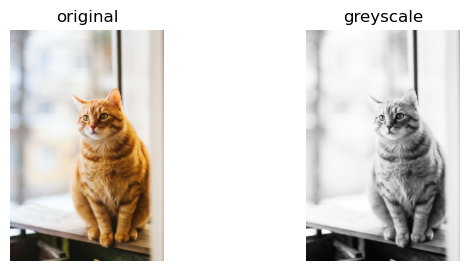

In [5]:
fig, axarr = plt.subplots(1, 2, figsize = (7, 3))

def to_greyscale(im):
    return 1 - np.dot(im[...,:3], [0.2989, 0.5870, 0.1140])

grey_img = to_greyscale(myimg)

axarr[0].imshow(myimg)
axarr[0].axis("off")
axarr[0].set(title = "original")

axarr[1].imshow(grey_img, cmap = "Greys")
axarr[1].axis("off")
axarr[1].set(title = "greyscale")

Now, our image is in greyscale, and it is represented in the python notebook as numpy array. Let's check the dimension of this array once more just to be sure.

In [6]:
print(grey_img.shape[0])
print(grey_img.shape[1])

2657
1771


We have introduced the concept of singular value decompostion, but how do we compute it? If we want to compute it by hand, then there are quite a few mathematical steps to follow. However, for the purpose of this blog, we just need to use the following numpy snippet:
`U, sigma, V = np.linalg.svd(A)`.
And we will get the matrices `U`, `sigma`, and `V` returned to us as numpy arrays. This numpy function is very useful, and it helped us a great deal in our implementation of image processing, which now import.  

In [7]:
from hidden_images import svd
svd1 = svd()

The main thing we implemented is a function called `reconstruct()` that takes an image (represented as a numpy array), use `np.linalg.svd()` to perform the singular decomposition on it, then we truncate the singular values and only use the first $k$ of them, so we use index slicing to obtain the truncated version of `V`, `Sigma`, and `U`, and we multiply them together again to obtain the reconstructed image, which takes up less storage. If we pick a small number of singular values, i.e., a small $k$, our picture will look like it has pretty low resolution. The picture below on the left shows the original image, and the picture on the right shows the reconstructed image, which in this case, has a reasonable resolution, since we selected a relatively sizable $k=18$. 

As for how to do the numpy array slicing to only use the first $k$ singular values, we could use the following code snippet as shown in the main reference we have listed under ### Source. Let us attach an underscore `_` to the letter denoting we have truncated this matrix.

`U_ = U[:,:k]` means we take the first $k$ columns of $U$ to form `U_`.

`D_ = D[:k, :k]` means we take the upper left $k\times k$ square matrix from $D$ to form `D_`.

`V_ = V[:k,:]` means we take the first $k$ rows from $V$ to form `V_`.


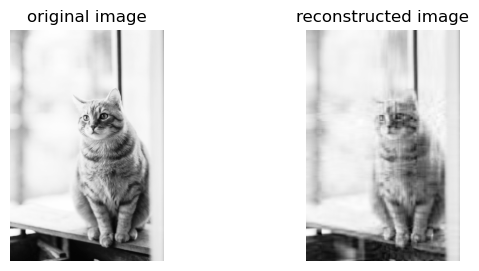

In [8]:
k = 18 
A_ = svd1.reconstruct(grey_img, k)
svd1.compare_images(grey_img, A_)

Now, we perform an experiment, which is implemented in the `experiment` function. Basically, we start with using only $3$ singular values, and we increase the number of ingular values by $5$ each time, until the reconstructed image looks roughly the same just from looking at it. Meanwhile, as we print out these images, we also print a string showing how much storage (in percentage of the original picture) that our reconstructed image takes up. 

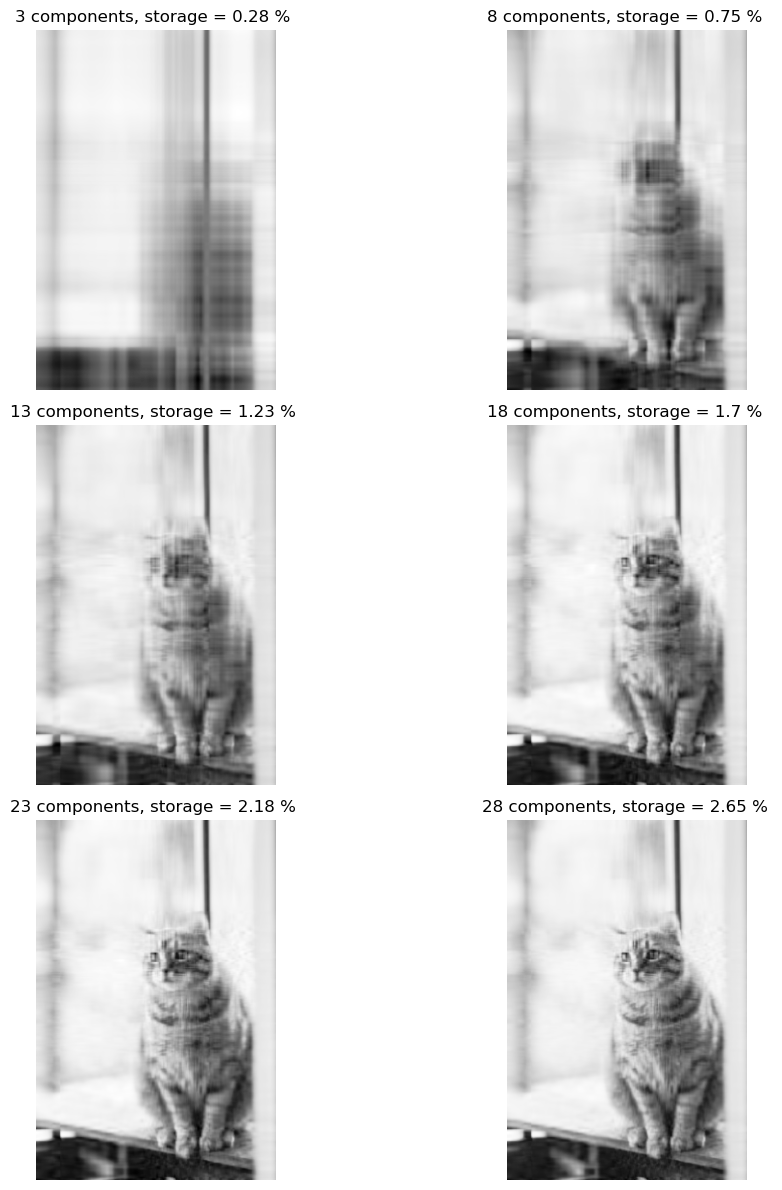

In [9]:
svd1.experiment(grey_img) 

We see that at $28$ singular values, our reconstructed picture of the cat already looks pretty much the same as the orignal image, albeit slightly grainy. However, the exciting thing is that now, we only need $2.65$ percent of the original storage space for this reconstructed image! So we sacrifice a little image sharpness, and greatly reduce the storage we needed to store this image! 

# Part II: Spectral Community Detection

We need to return a vector of binary labels to split the graph.

# Implementing Laplacian Spectral Clustering 

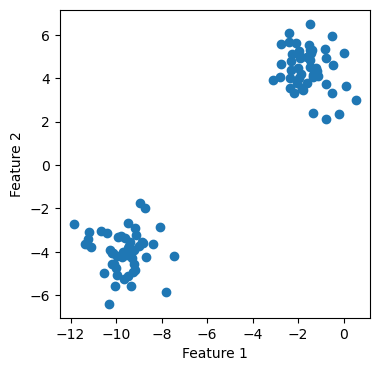

In [10]:
from sklearn.datasets import make_blobs, make_circles
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(12345)

fig, ax = plt.subplots(1, figsize = (4, 4))
X, y = make_blobs(n_samples=100, n_features=2, 
                                centers=2, random_state=1)

a = ax.scatter(X[:, 0], X[:, 1])
a = ax.set(xlabel = "Feature 1", ylabel = "Feature 2")

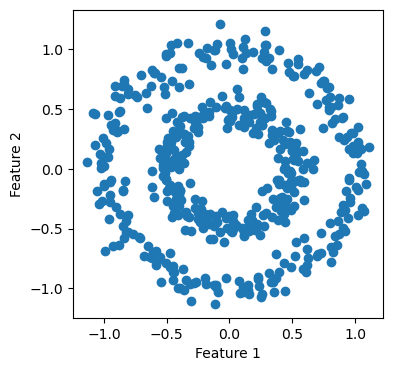

In [11]:
np.random.seed(42)

n = 500
X, y = make_circles(n_samples=n, shuffle=True, noise=0.07, random_state=None, factor = 0.5)

fig, ax = plt.subplots(1, figsize = (4, 4))
a = ax.scatter(X[:, 0], X[:, 1])
a = ax.set(xlabel = "Feature 1", ylabel = "Feature 2")

In [12]:
from sklearn.neighbors import NearestNeighbors

k = 10
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
A = nbrs.kneighbors_graph().toarray()

# symmetrize the matrix
A = A + A.T
A[A > 1] = 1

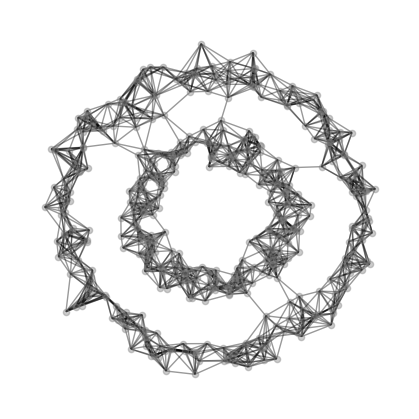

In [13]:
import networkx as nx
from hidden_spectral import spectral 
spec  = spectral()
plt.rcParams["figure.figsize"] = (4,4)
spec.plot_graph(X, A)

In [14]:
# fig, axarr = plt.subplots(1, 2, figsize = (8, 4))
y_bad = np.random.randint(0, 2, n)

# plot_graph(X, A, z = y, ax = axarr[0])
# plot_graph(X, A, z = y_bad, ax = axarr[1])

In [15]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
def cut(A, z):
    D = pairwise_distances(z.reshape(-1, 1))
    return (A*D).sum()
    
print(f"good labels cut = {cut(A, z = y)}") 
print(f"bad labels cut = {cut(A, z = y_bad)}") 

def cut(A, z):
    D = pairwise_distances(z.reshape(-1, 1))
    return (A*D).sum()
    
print(f"good labels cut = {cut(A, z = y)}") 
print(f"bad labels cut = {cut(A, z = y_bad)}") 

good labels cut = 22.0
bad labels cut = 3000.0
good labels cut = 22.0
bad labels cut = 3000.0


# Use a theorem from linear algebra
$z$ should be the eigenvector with the second smallest eigenvalue of the matrix $$L = D^{-1}\left[ D-A \right]. $$ This matrix $L$ is called the normalized Laplacian.

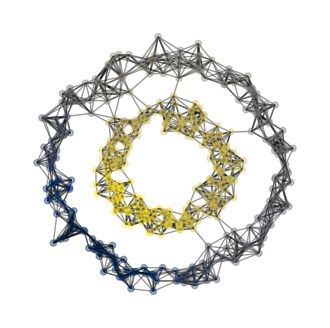

In [16]:
from hidden_spectral import spectral 
spec = spectral()
fig, ax = plt.subplots(figsize = (4, 4))
z_ = spec.second_laplacian_eigenvector(A=A)
spec.plot_graph(X, A, z=z_, ax = ax, show_edge_cuts = False)

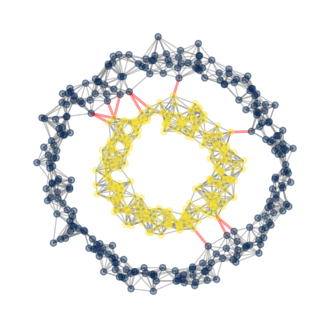

In [17]:
z = z_ > 0
fig, ax = plt.subplots(figsize = (4, 4))
spec.plot_graph(X, A, z, show_edge_cuts = True, ax = ax)

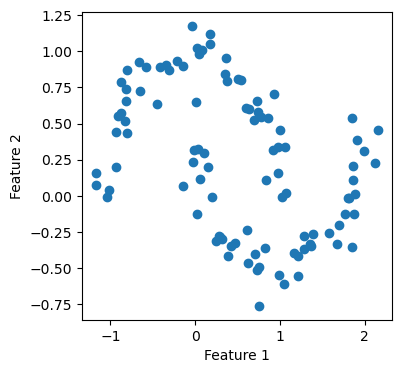

In [18]:
from sklearn.datasets import make_moons

H, z = make_moons(n_samples=100, random_state=1, noise = .1)
fig, ax = plt.subplots(figsize = (4, 4))
a = ax.scatter(H[:, 0], H[:, 1])
a = ax.set(xlabel = "Feature 1", ylabel = "Feature 2")

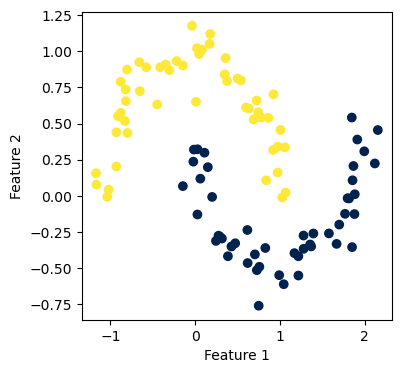

In [19]:
fig, ax = plt.subplots(figsize = (4, 4))
z_hat = spec.spectral_clustering(H, k=6)
a = ax.scatter(H[:, 0], H[:, 1], c = z_hat, cmap = plt.cm.cividis)
a = ax.set(xlabel = "Feature 1", ylabel = "Feature 2")

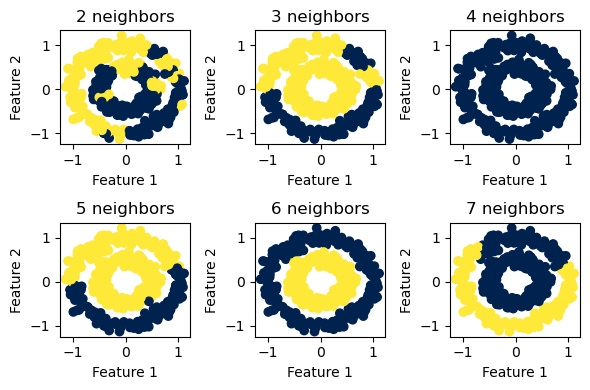

In [20]:
fig, axarr = plt.subplots(2, 3, figsize = (6, 4))

i = 2
for ax in axarr.ravel():
    z = spec.spectral_clustering(X, k = i)
    a = ax.scatter(X[:, 0], X[:, 1], c = z, cmap = plt.cm.cividis)
    a = ax.set(xlabel = "Feature 1", ylabel = "Feature 2", title = f"{i} neighbors")
    i += 1

plt.tight_layout()

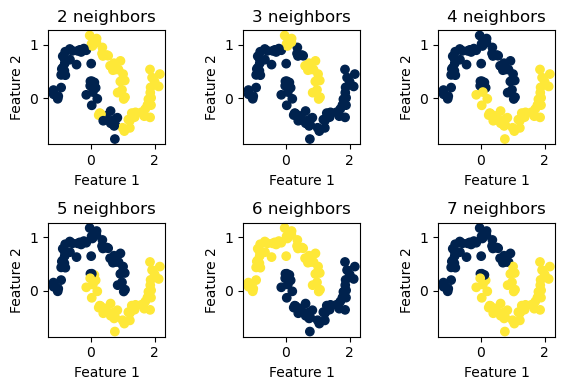

In [21]:

fig, axarr = plt.subplots(2, 3, figsize = (6, 4))

i = 2
for ax in axarr.ravel():
    z = spec.spectral_clustering(H, k = i)
    a = ax.scatter(H[:, 0], H[:, 1], c = z, cmap = plt.cm.cividis)
    a = ax.set(xlabel = "Feature 1", ylabel = "Feature 2", title = f"{i} neighbors")
    i += 1

plt.tight_layout()

$$\mathcal{L}(a, b) = \sum_{i = 1}^n (ax_i + b - y_i)^2\;.$$

# Testing

In [22]:

L = np.diag([4,5,22,2,3])
# print(L)
evalue, evector = np.linalg.eig(L)
print("evalue")
print(evalue)
print("evector")
print(evector)
k = L.shape[1] 
idx = evalue.argsort()[:k][::-1] 
evalue = evalue[idx]
evector = evector[:, idx]

print("evalue after change")
print(evalue)
print("evector after change")
print(evector)

index = evector.shape[1]
print("col")
print(evector[:,index-2])

evalue
[ 4.  5. 22.  2.  3.]
evector
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
evalue after change
[22.  5.  4.  3.  2.]
evector after change
[[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]
col
[0. 0. 0. 0. 1.]


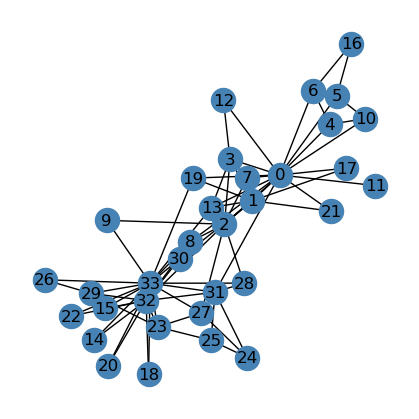

In [23]:
import networkx as nx
G = nx.karate_club_graph()
layout = nx.layout.fruchterman_reingold_layout(G)
nx.draw(G, layout, with_labels=True, node_color = "steelblue")

In [25]:
clubs = nx.get_node_attributes(G, "club")
z_hat = spec.spectral_clustering(G, k=6)

nx.draw(G, layout,
        with_labels=True, 
        node_color = ["orange" if clubs[i] == "Officer" else "steelblue" for i in G.nodes()],
        edgecolors = "black" # confusingly, this is the color of node borders, not of edges
        ) 

ValueError: Expected 2D array, got 1D array instead:
array=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.